In [ ]:
!pip install pytube
!pip install plotly
!pip install git+https://github.com/openai/CLIP.git
!pip install torch

     |████████████████████████████████| 56 kB 3.6 MB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bbqlewib
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-bbqlewib
     |████████████████████████████████| 53 kB 1.6 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=bfc1bdbee0c07e21b53b2d17d4b8bc445619b18f405adb5cedf3f5023433a3b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-ixe7vmbo/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
from IPython.core.display import HTML
import plotly.express as px
from pytube import YouTube
from PIL import Image
import numpy as np
import datetime
import cv2
import clip
import torch
import math

class video_parser:
    def __init__(self, url, search, batch_size = 256):
        self.url = url
        self.search = search
        self.batch_size = batch_size

    def download_vid(self, video_url):
        streams = YouTube(video_url).streams.filter(adaptive=True, subtype="mp4", resolution="360p", only_video=True)
        if len(streams) == 0:
          raise "Enter a video compatible with the program"
        print("Downloading...")
        streams[0].download(filename="video.mp4") ## Downloads the video for use later
        print("Download completed.")
        return streams

    def text_analysis(self, search_query, model, device):
      with torch.no_grad():
        text_features = model.encode_text(clip.tokenize(search_query).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
      return text_features

    ## Pull individual frames of the video
    def get_frames(self, N):
        video_frames = []

        capture = cv2.VideoCapture('video.mp4') ## have the program look through downloaded file
        fps = capture.get(cv2.CAP_PROP_FPS) ## get FPS data for the video

        current_frame = 0
        while capture.isOpened(): ## Loop through the video
          ret, frame = capture.read() 

          if ret == True:
            video_frames.append(Image.fromarray(frame[:, :, ::-1]))
          else:
            break

          current_frame += N ## Skip designated frames which will speed up the process
          capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame) 

        print(f"Frames extracted: {len(video_frames)}") # Print some statistics
        return video_frames, fps

    def get_clump(self, N, device, model, preprocess, search_query):
        video_frames, fps = self.get_frames(N)
        frames, fps = self.get_frames(15)
        groups = 10
        #batches = math.ceil(len(video_frames) / batch_size)
        batches = len(frames) // groups

        ## for measuring a deviation from the mean with in frame clump
        video_frames = []
        for j in range(groups):
          many = preprocess(frames[j * batches])
          for i in range(batches):
            many += preprocess(frames[i + (j * batches)])
          average = many / batches
          start = average * 0 
          for s in range(batches):
            start += average - preprocess(frames[s + (j * batches)])
          video_frames.append(start)

        ## for getting the sum of the frames
        # video_frames = []
        # for j in range(groups):
        #   many = preprocess(frames[j * batches])
        #   for i in range(batches):
        #     many += preprocess(frames[i + (j * batches)]) 
        #   video_frames.append(many)

        ## for getting the average of the frames
        # video_frames = []
        # for j in range(groups):
        #   many = preprocess(frames[j * batches])
        #   for i in range(batches):
        #     many += preprocess(frames[i + (j * batches)]) 
        #     many = many / batches
        #   video_frames.append(many)

        ## for getting the square root of the sum of squares
        # video_frames = []
        # for j in range(groups):
        #   many = preprocess(frames[j * batches]) ** 2
        #   for i in range(batches):
        #     many += preprocess(frames[i + (j * batches)]) ** 2
        #     many = many / batches
        #     many = many ** 1/2
        #   video_frames.append(many)

        video_features = torch.empty([0, 512], dtype=torch.float16).to(device) ## Creates a place for encoded files which will be used for querys

        for i in range(groups): ## Process in batches

          batch_frames = video_frames[i: i + 1] ## looks through for the relevent frames
          batch_preprocessed = torch.stack([(frame) for frame in batch_frames]).to(device) ## Preprocesses the images
          
          with torch.no_grad():
            batch_features = model.encode_image(batch_preprocessed) # Uses CLIP to encode and Normalize
            batch_features /= batch_features.norm(dim=-1, keepdim=True)

          video_features = torch.cat((video_features, batch_features))

        text_features = self.text_analysis(search_query, model, device)
        similarities = (100.0 * video_features @ text_features.T)
        print(similarities)
        v, bf = similarities.topk(1, dim=0)

        video_frames = frames[bf * batches:(bf + 1) * batches]
        return video_frames, fps


    ## This function transforms the video features into the word vectors
    def get_vid_feat(self, N, device, preprocess, model, batch_size, search_query): 
        #video_frames, fps = self.get_frames(N)
        video_frames, fps = self.get_clump(N, device, model, preprocess, search_query)
        batch_size = batch_size
        batches = math.ceil(len(video_frames) / batch_size)

        video_features = torch.empty([0, 512], dtype=torch.float16).to(device) ## Creates a place for encoded files which will be used for querys

        for i in range(batches): ## Process in batches

          batch_frames = video_frames[i*batch_size : (i+1)*batch_size] ## looks through for the relevent frames
          batch_preprocessed = torch.stack([preprocess(frame) for frame in batch_frames]).to(device) ## Preprocesses the images
          
          with torch.no_grad():
            batch_features = model.encode_image(batch_preprocessed) # Uses CLIP to encode and Normalize
            batch_features /= batch_features.norm(dim=-1, keepdim=True)

          video_features = torch.cat((video_features, batch_features))

        return video_features


    def search_video(self, search_query, N, video_url, device, preprocess, model, batch_size, display_heatmap=True, display_results_count=3):

      video_features = self.get_vid_feat(N, device, preprocess, model, batch_size, search_query)
      video_frames, fps = self.get_frames(N)

      # Encode and normalize the search query using CLIP

      text_features = self.text_analysis(search_query, model, device)

      similarities = (100.0 * video_features @ text_features.T) ## Finding the best similarities through cosine similarities. 
      values, best_photo_idx = similarities.topk(display_results_count, dim=0)

      if display_heatmap: ## Creating a heat map for the video
        print("Search query heatmap over the frames of the video:")
        fig = px.imshow(similarities.T.cpu().numpy(), height=50, aspect='auto', color_continuous_scale='viridis')
        fig.update_layout(coloraxis_showscale=False)
        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=False)
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.show()
        print()

      for frame_id in best_photo_idx: ## Chooses the top three matches
        display(video_frames[frame_id])

        seconds = round(frame_id.cpu().numpy()[0] * N / fps) ## Compute and show the time stamp of the match
        display(HTML(f"Found at {str(datetime.timedelta(seconds=seconds))} (<a target=\"_blank\" href=\"{video_url}&t={seconds}\">link</a>)")) 
        ## link to the spot in the video


    ## Running the whole program
    def show_matches(self):
      # Load the open CLIP model
      device = "cuda" if torch.cuda.is_available() else "cpu"
      model, preprocess = clip.load("ViT-B/32", device=device)
      self.download_vid(self.url)
      self.search_video(self.search, 30, self.url, device, preprocess, model, self.batch_size)

Input a youtube link: https://www.youtube.com/watch?v=z2z857RSfhk
What do you want to search the video for? a guy in sunglasses
Downloading...
Download completed.
Frames extracted: 129
Frames extracted: 257
tensor([[22.9219],
        [20.1875],
        [21.6875],
        [20.1406],
        [23.2969],
        [17.6250],
        [22.0156],
        [21.0625],
        [21.0469],
        [18.8594]], device='cuda:0', dtype=torch.float16)
Frames extracted: 129
Search query heatmap over the frames of the video:


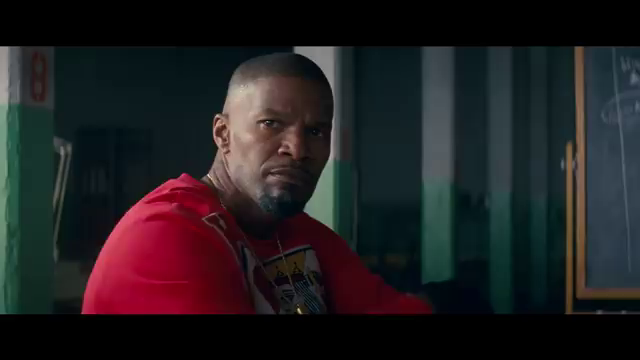

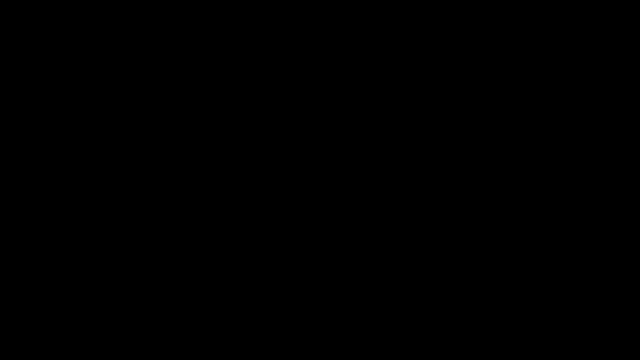

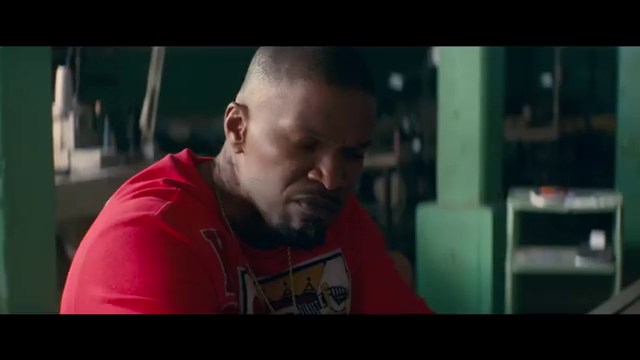

In [ ]:
video_parser(input('Input a youtube link: '),input('What do you want to search the video for? ')).show_matches()

In [ ]:
# batman trailer link "https://www.youtube.com/watch?v=mqqft2x_Aa4"